# Playground for SLM Phase Patterns

**Discription:** This Notebook generates phase patterns for the Spatial Light Modulator (SLM). <br>
**Author(s):** *M. Fränzl and N. Söker*

## Required Packages

In [147]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from skimage.util import invert 

# Package need to export 16 bit TIF images
import tifffile as tiff 
# Windows: If you get an error with "pip install tifffile" install the Build Tools for Visual Studio (https://visualstudio.microsoft.com/downloads/)

from scipy.fftpack import ifftn,fftn

## SLM and Setup Settings

Setup the parameters for the SLM and the setup

In [95]:
# Dimension of the SLM in pixel
dimx = 512
dimy = 512
# Pixel pitch in micrometer
pp = 15
# Wavelength in nanometer
lda = 532

x, y = np.meshgrid(np.arange(x_max), np.arange(y_max))

## Grating Phase Pattern (XY Displacement)

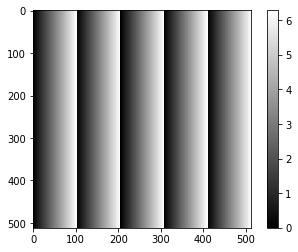

In [120]:
# Grating periods in ???
g_x = 10;
g_y = 0;
phase_grating = np.mod(pi*g_x/dimx*x + pi*g_y/dimy*y, 2*pi);

plt.imshow(im, cmap='gray')
plt.imshow(phase_grating, cmap='gray', vmin=0, vmax=2*pi)
plt.colorbar()
plt.show()

In [121]:
# Convert phase to 16 bit 
phase_grating = phase_grating/(2*pi)*65535 # 2**16 - 1

### Fresnel Lens Phase Pattern (Focusing)

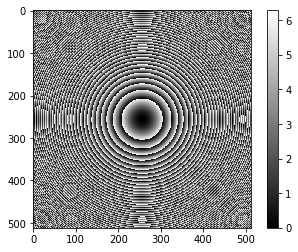

In [124]:
# Focal length in mm
f = 500
phase_fresnel = np.mod(pi/(lda*1e-9*f*1e-3)*((x - dimx/2)**2 + (y - dimy/2)**2)*(pp*1e-6)**2, 2*pi)

plt.imshow(phase_fresnel, cmap='gray', vmin=0, vmax=2*pi)
plt.colorbar()
plt.show()

In [125]:
# Convert phase to 16 bit 
phase_fresnel = phase_fresnel/(2*pi)*65535 # 2**16 - 1

## Load the Image you want to Display with the SLM

In [152]:
im = plt.imread("ThorLabsDog.png")
im.shape

(4517, 4296, 3)

In [153]:
# take only the first channel 
im = im[:,:,0]
# invert image
im = invert(im)

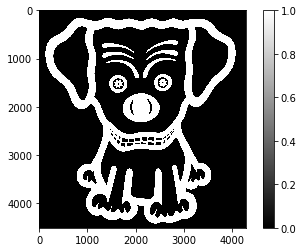

In [154]:
plt.imshow(im, cmap='gray')
plt.colorbar()
plt.show()

In [155]:
# resize
im = resize(im, (512, 512), mode='constant') # preserve_range=True

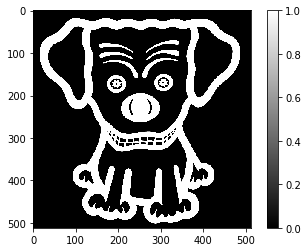

In [156]:
plt.imshow(im, cmap='gray')
plt.colorbar()
plt.show()

In [157]:


def phase(u):
    return np.arctan2(np.imag(u), np.real(u))

### Gerchberg–Saxton (GS) Algorithm

In [158]:
source = np.zeros((dimx, dimy)) + 1
target = im
n = 0
A = fftn(target)
while n < 10:
    B = source*np.exp(phase(A)*1j)
    C = fftn(B)
    D = target*np.exp(1j*phase(C))
    A = ifftn(D)
    n +=1

This is just one of the many ways to implement the GS algorithm. Apart from from optimizations, others may start by performing a forward Fourier Transform to the source distribution.

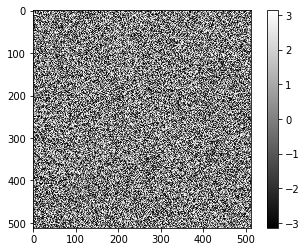

In [159]:
plt.imshow(phase(A), cmap='gray')
plt.colorbar()
plt.show()

In [160]:
# Convert phase from -pi, pi to 0, 2*pi
phase_image = phase(A)+np.pi
# Convert phase to 16 bit 
phase_image = phase_image/(2*pi)*65535 # 2**16 - 1

## Add all Phase Images

In [161]:
#phase_total = np.mod(phase_grating, 2**16)
#phase_total = np.mod(phase_fresnel, 2**16)
#phase_total = np.mod(phase_image, 2**16)
#phase_total = np.mod(phase_grating + phase_fresnel, 2**16)
phase_total = np.mod(phase_grating + phase_fresnel + phase_image, 2**16)

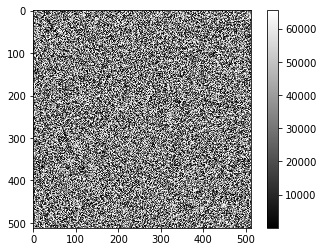

In [162]:
plt.imshow(phase_total, cmap='gray')
plt.colorbar()
plt.show()

In [163]:
# save image es 16 bit TIF file
tiff.imsave('Total_Phase.tiff', phase_total.astype('uint16')) # resolution=(72,72)